# Análise de churn usando dados de rede

O objetivo da análise preditiva em redes é prever a qual classe um nó da rede poderá pertercer, como ser churner ou não, fraudador ou não, inadimplente ou não, etc.

No caso desse jupyter notebook será apresentada a análise preditiva em redes para análise de churn, o exemplo a seguir pode ser considerado como uma rede de usuários de serviço de telefonia móvel, e verificaremos a probabilidade de churn e de não-churn dos usuários em função de suas conexões com usuários churners. 

Definição de churn: em seu sentido mais amplo, é o número de indivíduos ou itens que saem de um grupo coletivo durante um período específico, no caso do exemplo a seguir seria o usuário que deixou de utilizar o serviço de telefonia móvel.

In [2]:
# Carregando os pacotes necessários
library(igraph)
library(dplyr)
library(expss)
library(Matrix)
library(pROC)

In [4]:
# Carregando o arquivo edgeList.csv e customers.csv
edgeList <- read.csv("edgeList.csv", sep = ";")
customers <- read.csv("customers.csv", sep = ";")

In [6]:
# Inspecionando o dataframe "edgeList"
head(edgeList)
str(edgeList)

from,to
1,250
1,308
1,413
1,525
1,803
1,894


'data.frame':	1663 obs. of  2 variables:
 $ from: int  1 1 1 1 1 1 2 2 2 2 ...
 $ to  : int  250 308 413 525 803 894 332 433 474 847 ...


In [9]:
# Criando o objeto do igraph
network <- graph_from_data_frame(edgeList, directed = FALSE)

# Visualizando o objeto igraph
network

IGRAPH 2869363 UN-- 956 1663 -- 
+ attr: name (v/c)
+ edges from 2869363 (vertex names):
 [1] 1 --250 1 --308 1 --413 1 --525 1 --803 1 --894 2 --332 2 --433 2 --474
[10] 2 --847 2 --963 2 --968 3 --147 3 --290 3 --337 3 --393 3 --474 4 --179
[19] 4 --193 4 --233 5 --737 5 --793 5 --838 6 --684 6 --718 7 --237 7 --404
[28] 8 --698 8 --724 10--285 10--641 11--86  11--285 11--376 11--689 11--758
[37] 11--889 12--145 12--410 12--544 13--583 13--835 14--96  14--788 14--924
[46] 15--43  15--91  15--446 16--181 16--289 16--378 16--406 16--547 16--784
[55] 17--189 17--399 17--482 17--822 18--262 18--308 18--817 18--832 19--260
[64] 19--997 20--81  20--229 20--839 21--56  21--840 22--183 23--186 23--397
+ ... omitted several edges

In [10]:
# Inspecionando o dataframe "customers"
head(customers)
str(customers)

id,churn
1,0
250,0
308,0
413,0
525,0
803,0


'data.frame':	956 obs. of  2 variables:
 $ id   : int  1 250 308 413 525 803 894 2 332 433 ...
 $ churn: int  0 0 0 0 0 0 0 0 0 0 ...


In [11]:
# Contanto o número churners e de não-churners
table(customers$churn)


  0   1 
926  30 

In [13]:
# Adicionando atributo de nó "churn"
V(network)$churn <- customers$churn

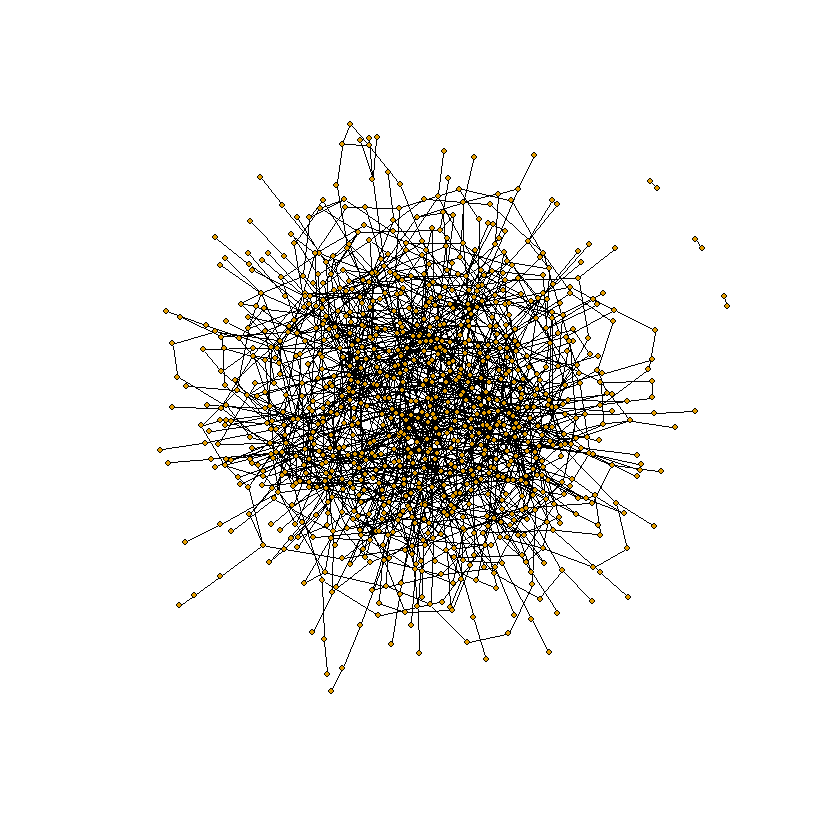

In [14]:
# vizualizando a rede
plot(network, 
     vertex.label = NA, 
     edge.label = NA, 
     edge.color = 'black', 
     vertex.size = 2)

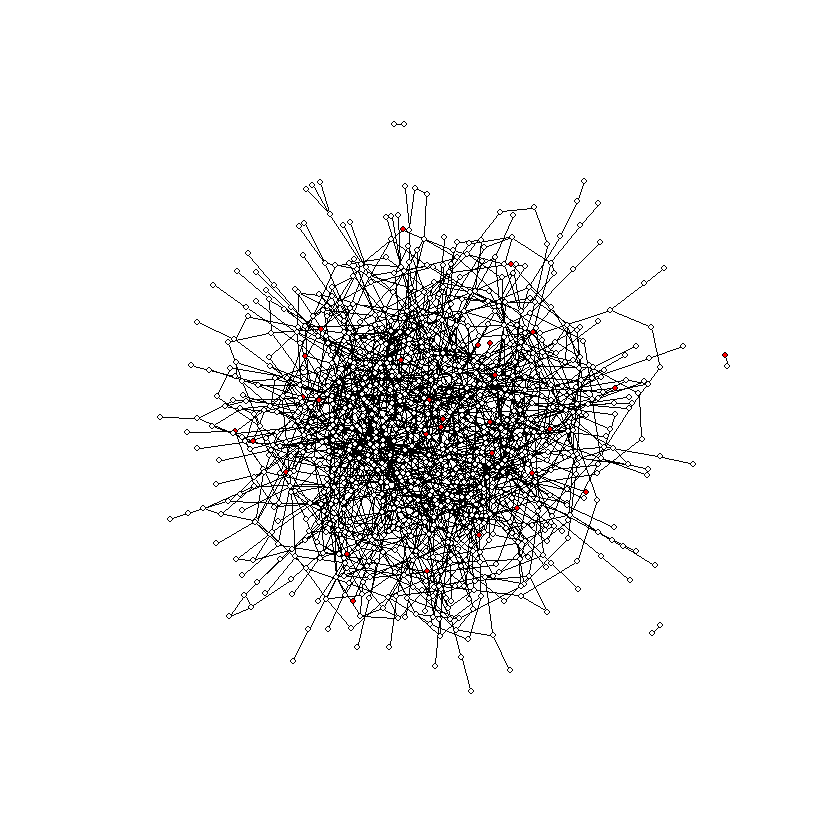

In [17]:
# Adicionando atributo de nó "color"
V(network)$color <- V(network)$churn

# Mudando a cor dos churners para vermelho e dos não-churners para branco
V(network)$color <- gsub('1', "red", V(network)$color)
V(network)$color <- gsub('0', "white", V(network)$color)

# visualizando a rede
plot(network, 
     vertex.label = NA, 
     edge.label = NA,
     edge.color = 'black', 
     vertex.size = 2)

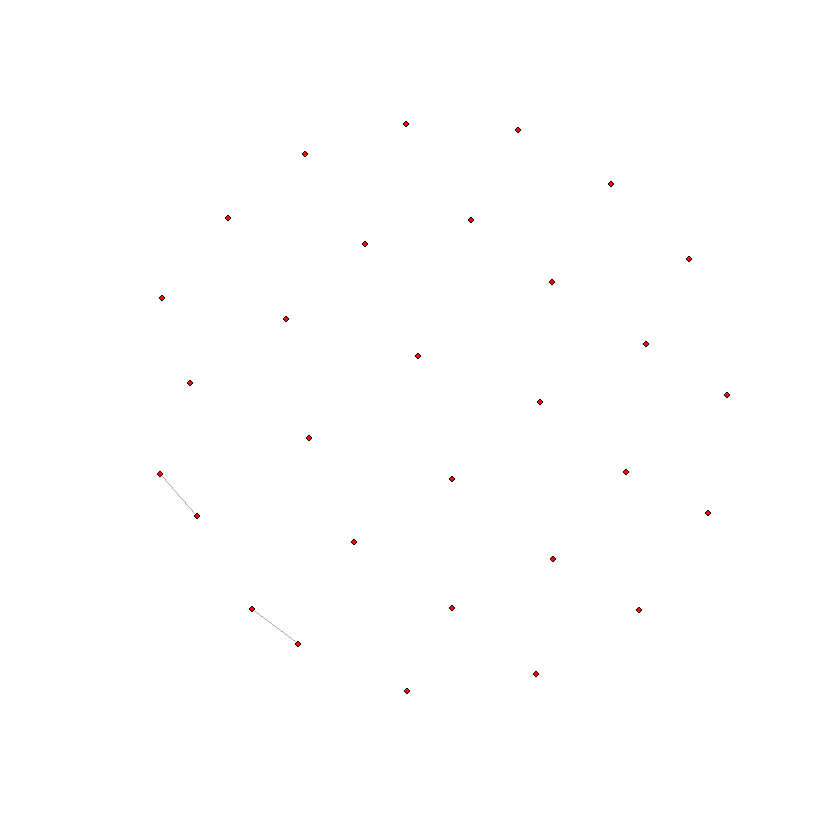

In [18]:
# Criando um subgrafo somente com os churners
churnerNetwork <- induced_subgraph(network, v = V(network)[which(V(network)$churn == 1)])

# Visualizando o rede de churners
plot(churnerNetwork, vertex.label = NA, vertex.size = 2)

## Probabilidade de churn via "relational neighbor classifier" (RN)

In [20]:
# Criando data frame com os graus por id (contagem de vizinhos por nó)
countNeighbors <- add_rownames(as.data.frame(degree(network)), var = "id")
colnames(countNeighbors)[2] <- "count"
countNeighbors$id <- as.numeric(countNeighbors$id)
countNeighbors$count <- as.numeric(countNeighbors$count)

Warning message:
"Deprecated, use tibble::rownames_to_column() instead."

In [22]:
# Criando o dataframe com a contagem de vizinhos churners por id
countChurnerNeighborsFrom <- edgeList %>%
  mutate(churn = vlookup(edgeList$to, customers, lookup_column = 1, result_column = 2)) %>%
  group_by(from) %>%
  summarise(count_from = sum(churn))

countChurnerNeighborsTo <- edgeList %>%
  mutate(churn = vlookup(edgeList$from, customers, lookup_column = 1, result_column = 2)) %>%
  group_by(to) %>%
  summarise(count_to = sum(churn))

countChurnerNeighbors <- select(customers, "id")
  
countChurnerNeighbors <- mutate(countChurnerNeighbors, count_from = vlookup(countChurnerNeighbors$id, 
                                                                            countChurnerNeighborsFrom, 
                                                                            lookup_column = 1, 
                                                                            result_column = 2))

countChurnerNeighbors <- mutate(countChurnerNeighbors, count_to = vlookup(countChurnerNeighbors$id, 
                                                                          countChurnerNeighborsTo, 
                                                                          lookup_column = 1, 
                                                                          result_column = 2))

countChurnerNeighbors[is.na(countChurnerNeighbors)] <- 0

countChurnerNeighbors <- mutate(countChurnerNeighbors, total = count_from + count_to)

In [23]:
# Cálculo da probabilidade através do "relational neighbor classifier"
churnProb <- customers %>%
  select("id") %>%
  mutate(count_neighbors = vlookup(customers$id, countNeighbors, lookup_column = 1, result_column = 2),
         count_churner_neighbors = vlookup(customers$id, countChurnerNeighbors, lookup_column = 1, result_column = 4),
         churn_prob = count_churner_neighbors / count_neighbors)

In [24]:
# Encontrando quem tem maior probabilidade de churn
Churners <- which(churnProb$churn_prob >= 0.5)

mostLikelyChurners <- which(churnProb$churn_prob == max(churnProb$churn_prob))

In [25]:
# extraindo os IDs com maior probabilidade de churn
customers$id[Churners]

customers$id[mostLikelyChurners]

[1]   8 399 483  49 326 995 776 668 519 836 948 478 582 728 725

[1] 948 478

## Probabilidade de churn via "probabilistic relational neighbor classifier" (PRN)

In [26]:
# Ex.: encontrando a probabilidade do cliente de id "758" 
churnProb$churn_prob[churnProb$id == 758]

[1] 0.2

In [28]:
# Atualizando a probabilidade de churn e a probabilidade de não-churn

# Criando uma matriz de adjacência esparsa
AdjacencyMatrix <- as_adjacency_matrix(graph = network)
AdjacencyMatrix

   [[ suppressing 33 column names '1', '2', '3' ... ]]


956 x 956 sparse Matrix of class "dgCMatrix"
                                                                             
1    . . . . . . . . . . . . . . . . . . . 1 . . . . . . . . . . . . . ......
2    . . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
3    . . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
474  . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
4    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
5    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
6    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
7    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
8    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
10   . . . . . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . . ......
11   . . . . . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . . ......
285  . . . . . . . 

In [29]:
# Criando e ajustando a ordem do vetor da probabilidade de churn para o cálculo da PRN 
adj <- as.vector(as.numeric(row.names(AdjacencyMatrix)))

churnProb$id <- factor(churnProb$id, levels = adj)

churnProb <- churnProb[order(churnProb$id), ]

churnprobability <- as.vector(churnProb$churn_prob)

# criando o vetor com o número de vizinhos por id de cliente
neighbor <- as.vector(churnProb$count_neighbors)

# criando a coluna com os resultados do cálculo da probabilidade atualizada
churnProb$churn_prob_updated <- as.vector((AdjacencyMatrix %*% churnprobability) / neighbor)

# encontrando a probabilidade atualizada de churn do cliente de id 758
churnProb$churn_prob_updated[churnProb$id == 758]

[1] 0.2733333